In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import vocData as voc
import vocModel
from vocModel.utils import cal_iou
import time

import vocModel.nntools as nt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [3]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"
lr = 1e-3
batch_size = 8

In [4]:
def voc_data_loader():
    dataset = voc.VOCDetection(dataset_root_dir,  image_set = 'trainval')
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    validation_split = 0.1
    test_split = 0.1
    val_split = int(np.floor(validation_split * dataset_size))
    test_split = int(np.floor(test_split * dataset_size))

    np.random.shuffle(indices)

    train_indices, val_indices, test_indices = indices[val_split+test_split:],\
    indices[:val_split], indices[val_split:val_split+test_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler =  SubsetRandomSampler(test_indices)
    # Define data loaders
    train_loader = td.DataLoader(dataset, batch_size=batch_size, \
                                 sampler=train_sampler,\
                                 drop_last=True, pin_memory=True)

    val_loader = td.DataLoader(dataset, batch_size=batch_size,\
                               sampler=valid_sampler, \
                               drop_last=True, pin_memory=True)

    test_loader = td.DataLoader(dataset, batch_size=1,\
                               sampler=test_sampler, \
                               drop_last=False, pin_memory=False)

    return train_loader, val_loader, test_loader


In [5]:
train_loader, val_loader, test_loader = voc_data_loader()
print ("Dataset is divided into train :{}, val : {}, test :{} ".format(len(train_loader), len(val_loader), len(test_loader)))


Dataset is divided into train :1154, val : 144, test :1154 


In [6]:
# net = vocModel.YoloNet(7, 2, 20, 5,0.5)
net = vocModel.YoloNet_res(7, 2, 20, 5,0.5)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay = 5*1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.1)
stats_manager = vocModel.DetectionStatsManager()
exp1 = nt.Experiment(net, train_loader, val_loader, optimizer, stats_manager,batch_size=batch_size,
                     output_dir="data/resnet_3", perform_validation_during_training=True)

RuntimeError: CUDA error: out of memory

In [ ]:
class_dict = {'person' :0, 'bird' : 1, 'cat' : 2, 'cow': 3, 'dog': 4, 'horse' : 5, 'sheep' : 6,
                  'aeroplane' :7, 'bicycle' :8, 'boat' :9, 'bus':10, 'car':11, 'motorbike' :12, 'train':13,
                  'bottle' :14, 'chair':15, 'diningtable':16, 'pottedplant':17, 'sofa': 18, 'tvmonitor':19}
class_list = list(class_dict)

color_list = ['b', 'g', 'c', 'm', 'y', 'k', 'w']

In [90]:
def image_transform(image, ax=plt):
    normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])    
    image = np.array(normalize(image).numpy())
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    return image


def plot_single_image(output_bboxes, output_class_idx, gt_bboxes, gt_labels, axs) : 
    for i in range(gt_bboxes.size()[0]):
        xmin, ymin, xmax, ymax = gt_bboxes[i,:4]
        print ("GT",i,gt_bboxes[i,:].to('cpu').numpy(), class_list[gt_labels[i]])
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=4,edgecolor='r',facecolor='none')
        axs.add_patch(rect)

    for i in range(output_bboxes.size()[0]):
        xmin, ymin, xmax, ymax = output_bboxes[i,:4]
        t = output_class_idx[i]
        print (output_bboxes[i,:].to('cpu').numpy(), class_list[t])
        color = color_list[t % len(color_list)]
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color,facecolor='none')
        axs.add_patch(rect)

    
def from_target_to_bndboxes(bboxes, labels):

    mask = bboxes[:,3]>0.0
    
    gt_bboxes = bboxes[mask]*448.0
    gt_labels = labels[mask]

    return gt_bboxes, gt_labels.view(-1,1).byte()

    
    
def from_prediction_to_bndboxes(output, conf_threshold):
    
    output_bboxes =  output.view(-1, 30)[:,:10]
    maxi = torch.eq(output_bboxes[:,[4,9]], torch.max(output_bboxes[:,[4,9]], dim =1)[0].unsqueeze(1)).view(-1)
    output_bboxes = output_bboxes.contiguous().view(-1,5)[maxi]
    output_class_prob, output_labels = torch.max(output.view(-1, 30)[:,10:], dim = 1)
    output_bboxes[:,4] *= output_class_prob

    # calculate bndboxes to xmin, ymin, xmax, ymax
    cell_size = 1./7.0

    wh= torch.pow(output_bboxes[:,[2,3]], 2)
    ij = torch.from_numpy(np.array([ (i%C, i//C) for i in range(C*C)])).to(device).float()
    xy_center = (output_bboxes[:,[0,1]] + ij)* cell_size
    xy_min = xy_center - wh/2
    xy_min = torch.max(xy_min, torch.zeros_like(xy_min)) * 448.0
    xy_max = xy_center + wh/2
    xy_max = torch.min(xy_max, torch.ones_like(xy_min)) * 448.0
    output_bboxes[:,:4] = torch.cat((xy_min,  xy_max), dim = 1)

    # Choose high confidence bnd boxes
    conf_selected =output_bboxes[:,4] > conf_threshold
    output_bboxes = output_bboxes[conf_selected]
    output_labels = output_labels[conf_selected]
    
    return output_bboxes, output_labels.view(-1,1).byte()

In [96]:
conf_threshold = 0.1
ious_threshold = 0.5

In [97]:
s = time.time()
predictions = []
for i in range(len(class_dict)):
    predictions.append([])
print (predictions)
gt_class_count = torch.zeros(len(class_dict)).to(device)
print (gt_class_count)
test_iter = iter(test_loader)
print (len(test_loader))
net.eval()
with torch.no_grad():
    for img, target, bboxes, labels in test_loader:
#     for t in range(1):
#         img, target, bboxes, labels= next(test_iter)
        img, target, bboxes, labels= img.to(device).detach()\
        , target.to(device).detach(), bboxes.to(device).detach(), labels.to(device).detach()

        output = net.forward(img)
        output = output[0]
        target = target[0]
        bboxes = bboxes[0]
        labels = labels[0]

        # undo normailization
        img_mod = image_transform(img[0].to('cpu'))

        #gt variables
        gt_bboxes, gt_labels = from_target_to_bndboxes(bboxes, labels)
        
        # output to bndboxes
        output_bboxes, output_labels = from_prediction_to_bndboxes(output, conf_threshold)

#         #plot image
#         fig, axs = plt.subplots(ncols=1, figsize=(5, 5))
#         plot_single_image(output_bboxes, output_labels, gt_bboxes, gt_labels, axs)
#         axs.axis('off')
#         axs.imshow(img_mod)
    
        # Count number of GTs for each Class
        for i in range(gt_labels.size()[0]):
            t = gt_labels[i].item()
            gt_class_count[t] +=1

        #Classifying TP of FP
        for class_label in range(len(class_dict)):

            gt_mask = (gt_labels.view(-1) == class_label)
            output_mask = (output_labels.view(-1) == class_label)
            gt_bboxes_class = gt_bboxes[gt_mask]
            output_bboxes_class = output_bboxes[output_mask]

            ious = cal_iou(gt_bboxes_class, output_bboxes_class[:,:4])
            if ious.size()[1] == 0 :
                continue
            elif ious.size()[0] == 0 :
                for i in range(ious.size()[1]):
                    predictions[class_label].append((output_bboxes_class[i,4].item(), 0))                

            else :

                idxes = [(i,output_bboxes_class[i,4].item()) for i in range(ious.size()[1])]

                idxes = sorted(idxes, key = lambda x : x[1], reverse= True)

                unchosen_GT = list(range(ious.size()[0]))
                unchosen_BBOX = list(range(ious.size()[1]))

                for i in range(ious.size()[0]) :
                    maxi, max_idx = torch.max(ious[i,unchosen_BBOX].view(1,-1), dim = 1)

                    if (maxi > ious_threshold) :
                        choseon_idx = unchosen_BBOX[max_idx.item()]
                        unchosen_BBOX.pop(max_idx.item())
                        predictions[class_label].append((output_bboxes_class[choseon_idx,4].item(), 1))
                        if len(unchosen_BBOX) ==0:
                            break;
                            
                for left_idx in unchosen_BBOX:
                    predictions[class_label].append((output_bboxes_class[left_idx,4].item(), 0))        

print ("testing time : {}".format(time.time()-s))

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
1154
testing time : 347.77965354919434


# Calculating mAP

948.0


<IPython.core.display.Javascript object>


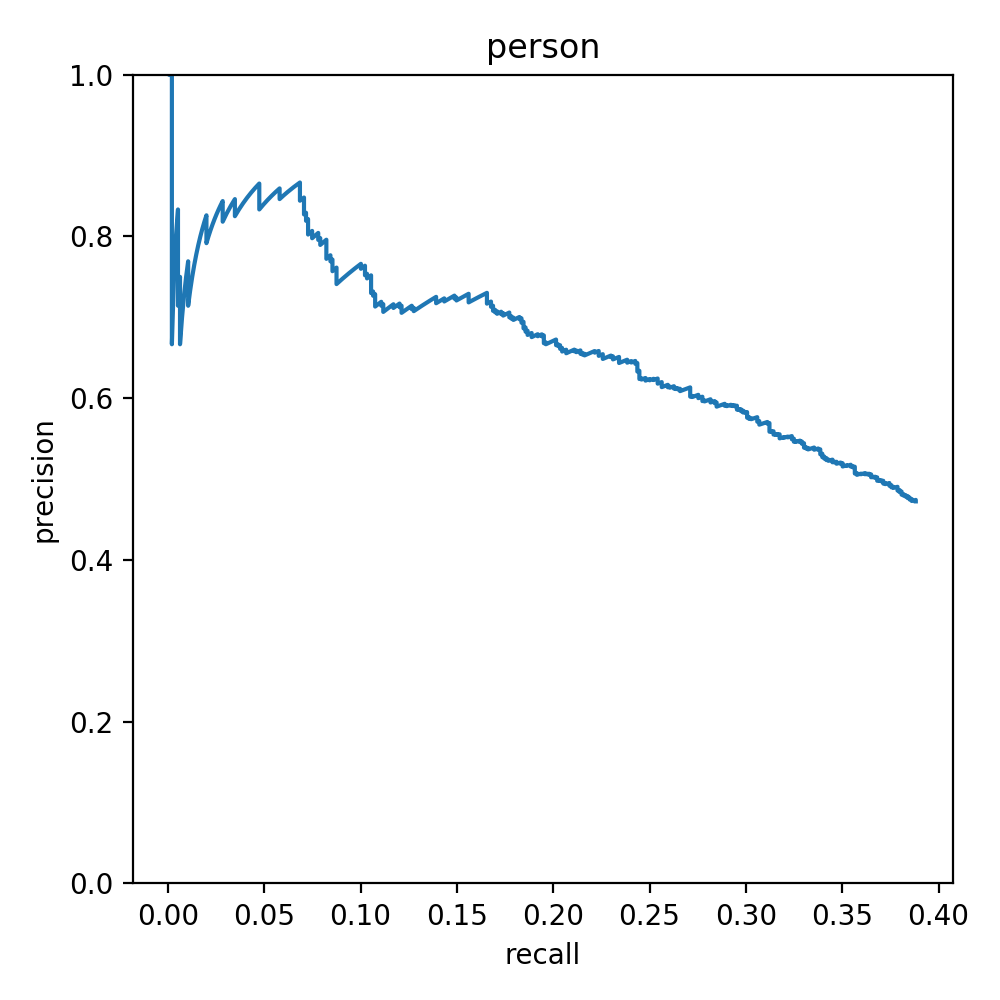

In [95]:
i=0
predicion_class = predictions[i]

predicion_class = sorted(predicion_class, key=lambda pred: pred[0], reverse = True)

precisions =[]
recalls = []
TPs = 0 
GT_TPs = gt_class_count[i].item()
print(GT_TPs)
for idx, (confidence, TP) in enumerate(predicion_class):
    
    TPs += TP
    
    curr_precision = TPs*1.0/(idx+1)
    curr_recall = TPs*1.0/GT_TPs

    precisions.append(curr_precision)
    recalls.append(curr_recall)
fig, axes = plt.subplots(ncols=1, figsize=(5, 5))

axes.clear()
axes.plot(recalls, precisions,
             label="people")
axes.set_xlabel("recall")
axes.set_ylabel("precision")
axes.set_ylim([0,1.0])
axes.set_xlim([0,1.0])
axes.set_title(class_list[i])
plt.tight_layout()
fig.canvas.draw()